<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.%203/3_5_BatchNorm_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [10]:
# warning message 제거
!pip install python-mnist==0.5
!pip install tensorflow

import warnings
warnings.filterwarnings(action='ignore')

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tensorflow import keras

import random

In [15]:
import torch.utils.data as data_utils
from torch.utils.data import DataLoader

# loss 값 ploting 을 위해 사용
import matplotlib.pyplot as plt

Check GPU and fix the random seed

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


### Load Dataset and preprocessing

In [17]:
mnist = keras.datasets.mnist
# MNIST 데이터셋 학습용(x,y), 테스트용(x,y)으로 나누기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data 는 list 형식을 되어 있으므로 shape 을 보고, 이미지 visualization 을 하기 편한 array 형태로 바꾸어준다.

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

print("x_train 의 shape={}, y_train 의 shape={}".format(x_train.shape,y_train.shape))
print("x_test 의 shape={}, y_test 의 shape={}".format(x_test.shape,y_test.shape))

x_train 의 shape=(60000, 28, 28), y_train 의 shape=(60000,)
x_test 의 shape=(10000, 28, 28), y_test 의 shape=(10000,)


### Convert dataset into Tensor

In [18]:
batch_size = 1000
traindata = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
trainloader = data_utils.DataLoader(traindata, batch_size = 1000, shuffle = True, drop_last = False)

### Make Batch_Norm_Class

In [19]:
class Batch_Norm(nn.Module):
    def __init__(self):
        super(Batch_Norm, self).__init__()

        self.network = nn.Sequential(nn.Linear(784,256),
                                     nn.BatchNorm1d(256),
                                     nn.ReLU(),
                                     nn.Linear(256,64),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(),
                                     nn.Linear(64,10)) # y=> 0~9    
                            
    def forward(self, x):
        output = self.network(x)
       

        return output
    
model = Batch_Norm().to(device)

In [24]:
model

Batch_Norm(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Set parameters

In [21]:
# learning_rate = 1e-3
# weight_decay = 0.1

In [25]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

### Data Train

In [ ]:
loss_list = []

for num_epoch in range(epoch):
    average_loss = 0
    
    for batch_idx , (x_data, y_data) in enumerate(trainloader):
        num_of_mini_batch = len(trainloader)
        
        x_Data = x_data.to(device)
        label = y_data.to(device)
        
        optimizer.zero_grad()
        
        y_predict = model(x_Data)
        
        y_label_long = torch.tensor(label, dtype = torch.long)
        y_label_long = y_label_long.to(device)
        
        loss = loss_function(y_predict, y_label_long)
        
        loss.backward()
        
        optimizer.step()
        
        loss_list.append(loss)
        
        average_loss += (loss.item()/num_of_mini_batch)
        
    print("Epoch = {}\tAverage loss = {}".format((num_epoch+1), average_loss))

### Check 3rd Epoch average Loss

In [ ]:
epoch_loss = 0
for i in range(60):
    epoch_loss = epoch_loss + loss_list[i+120]
    
print(epoch_loss/60)

tensor(0.0574, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
len(loss_list)

900

In [ ]:
from matplotlib import pyplot as plt

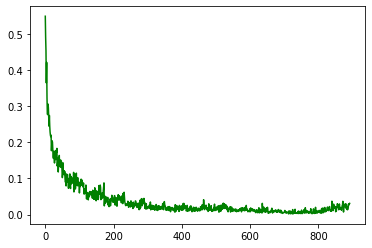

In [ ]:
plt.plot(np.array(loss_list[7:]), 'g')

In [ ]:
import pickle

# wb - 바이트 형식으로 저장

with open('BatchNorm.pickle', 'wb') as f:
    pickle.dump(loss_list, f)

### Test Code

In [ ]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size=5000, shuffle = False)

In [ ]:
with torch.no_grad():
    # model.eval()
    
    num_total_data = 0
    correct = 0
    
    for batch_idx, (image, label) in enumerate(testloader):
        
        x_data = image.to(device)
        label = label.to(device)
        predict = model(x_data).to(device)
        
        predict_sftmax = torch.nn.functional.softmax(predict)
        
        predict_label = torch.argmax(predict_sftmax, dim=1)
        
        num_total_data += len(image)
        # print(num_total_data)
        answer = sum(label==predict_label).item()
        correct += answer
        
    print("BatchNorm 을 적용했을 때의 accuracy %.2f%%" %((correct/num_total_data)*100))

BatchNorm 을 적용했을 때의 accuracy 97.66%
